In [10]:
import os
from DNASkittleUtils.DDVUtils import pp
import csv
from collections import defaultdict

# Lizzy's Data

In [1]:
from pandas import read_csv
liz = read_csv("GOenrich_db/lizzy_ash_ks.csv", sep='\t')
liz = liz[liz['Ks'] < 20]  # remove a couple bad values
print(len(liz), "pairs")

20865 pairs


In [4]:
wgd_recent = (liz['Ks'] > 0.16) & (liz['Ks'] < 0.38)
wgd_old = (liz['Ks'] > 0.5) & (liz['Ks'] < 0.8)
recent_duplication = liz['Ks'] < 0.2
unaffected =  ~wgd_old & ~recent_duplication  # ~wgd_recent &
affected = wgd_recent | wgd_old #| recent_duplication
len(liz[unaffected]), len(affected)
pp(len(liz[wgd_recent]) / len(liz))

'35.772825%'

In [5]:
liz.head()

,Group,Gene 1,Gene 2,Ks
0,10,130.1,342640.1,0.3768
1,10,130.1,254110.1,1.5491
2,10,130.1,83020.1,1.6002
3,10,342640.1,254110.1,2.8645
4,10,342640.1,83020.1,0.9481


In [6]:
from itertools import chain
def liz_rows_into_gene_list(liz):
    wgd_genes = set(['FRAEX38873_v2_' + str(x).zfill(11) for x in chain(liz['Gene 1'], liz['Gene 2'])])
    return wgd_genes
wgd_genes = liz_rows_into_gene_list(liz[wgd_recent])
pp(len(wgd_genes))

'13,033'

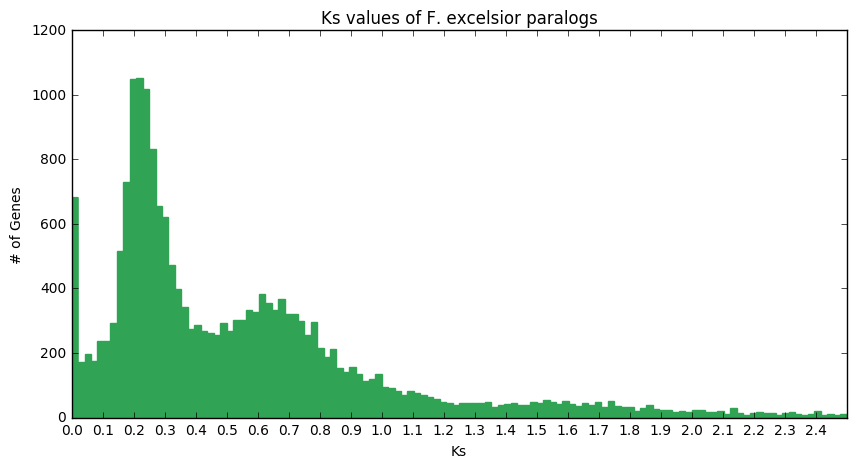

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.xticks(np.arange(0, 2.6, .1))
h = liz[liz['Ks'] < 2.5]['Ks'].hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel('Ks')
h.set_ylabel('# of Genes')
h.set_title('Ks values of F. excelsior paralogs')

In [16]:
ortho_file = r"Ash_Proteome\Results_Jun25\Orthogroups.csv"
orthogroups = {}
excelsior_orthogroups = {}
OG_order = []
with open(ortho_file, newline='' ) as csvfile:
    reader = csv.reader(csvfile, delimiter=' ')
    for nLines, row in enumerate(reader):
        og = row[0].replace(':','')
        orthogroups[og] = {'genes': list(row[1:])}
        if any([name.startswith('FRAEX') for name in orthogroups[og]['genes']]):
            excelsior_orthogroups[og] = orthogroups[og]
        OG_order.append(og)
        
gene2family = {gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [17]:
# wgd_genes = liz_rows_into_gene_list(liz[(liz['Ks'] > .2) & (liz['Ks'] < .3)])
wgd_by_family = set()
for gene in wgd_genes:
    if gene in gene2family:
        wgd_by_family.add(gene2family[gene])
len(wgd_by_family), pp(len(wgd_by_family) / len(excelsior_orthogroups))

(6105, '27.210733%')

**Conculsion** Functional orthogroups is prefiltered to only have families where members of excelsior are present. This 30% result then means that 30% of the gene families where we could have detected a WGD showed evidence of a WGD. That's very consistent with other numbers I've gotten.  
The 3% discrepancy (30-27) between FunctionsForFamilies is because of the annotation != "NULL" requirement, which is not included here. 

# CAFE tree approximations

In [20]:
from newick import loads
import newick

In [65]:
all_trees = {}
#fixed_JSG_all_species.cafe
with open(r"CAFE-4.1\data\cafe_orthofinder\reports\WGD_rates_loose.cafe", 'r') as csvfile: 
    lines = csvfile.readlines()[11:]
    for nLines, row in enumerate(lines):
        row = row.split('\t')
        all_trees[int(row[0])] = row[1]
len(all_trees)

27737

In [82]:
ordered_names = loads('(((((((((((FRAX30,FRAX32)<1>,FRAX28)<3>,FRAX12)<5>,(FRAX07,FRAX29)<9>)<7>,FRAX08)<11>,(((((FRAX01,FRAX16)<15>,FRAX15)<17>,FRAX00)<19>,(FRAX06,FRAX23)<23>)<21>,FRAX25)<25>)<13>,FRAX21)<27>,(((FRAX19,FRAX20)<31>,((FRAX11,FRAX27)<35>,FRAX04)<37>)<33>,(((((FRAX03,FRAX09)<41>,FRAX13)<43>,(FRAX26,FRAX14)<47>)<45>,FRAX05)<49>,FRAX33)<51>)<39>)<29>,FRAX31)<53>,Oeuropea)<55>,(Slycopersicum,Mguttatus)<59>)<57>')[0]
def create_ordered_nodes(verbose=False):
    ordered_nodes = []
    for node in ordered_names.walk(mode="preorder"):
        if verbose:
            print(node.name, node.length)
        ordered_nodes.append({'name': node.name, 'length':node.length, 'losses': 0, 'gains': 0, 'avg#': 0})
    return ordered_nodes
ordered_nodes = create_ordered_nodes()

In [83]:
def extract_count(name):
    if isinstance(name, newick.Node):
        name = name.name
    return int(name.split('_')[-1])

In [84]:
ordered_nodes[1]

{'avg#': 0, 'gains': 0, 'length': 0.0, 'losses': 0, 'name': '<55>'}

In [85]:
def get_count_at_root(fam_id, ordered_node_index=1):
    newick_str = all_trees[fam_id]
    tree = loads(newick_str)[0]
    for index, node in enumerate(tree.walk(mode="preorder")):
        if index == ordered_node_index:
            count = extract_count(node)
            return count

In [86]:
%%html
<img src="all_species_node_labels_WGD_manual.png">

## Filter Families to Ones with a Duplication at Root < 55 > 

In [87]:
def populate_history_histogram(study_ints):
    ordered_nodes = create_ordered_nodes()
    genes_lost = {node['name']:set() for node in ordered_nodes}
    gene_gains = {node['name']:set() for node in ordered_nodes}
    for fam_id in study_ints:
        if fam_id not in all_trees:
            continue
        newick_str = all_trees[fam_id]
        tree = loads(newick_str)[0]
        for index, node in enumerate(tree.walk(mode="preorder")):
            count = extract_count(node)
            tail = ''
            ordered_nodes[index]['avg#'] += count
            if node.ancestor:
                parent_count = extract_count(node.ancestor.name)
                if count < parent_count:
                    tail = ("loss")
                    ordered_nodes[index]['losses'] += 1 #parent_count - count
                    place_name = node.name.split('_')[0]
                    if place_name:
                        genes_lost[place_name].add(fam_id)  # record gene family
                elif count > parent_count:
                    tail = ("gain")
                    ordered_nodes[index]['gains'] += 1 #count - parent_count 
                    gene_gains[ordered_nodes[index]['name']].add(fam_id)
#             print(node.name, count, tail)
    for result in ordered_nodes:  # divide sum by length to get mean
        result['avg#'] /= len(study_ints)
    return ordered_nodes, genes_lost, gene_gains

study_ints = [int(fam[2:]) for fam in excelsior_orthogroups.keys()]
ordered_nodes, genes_lost, gene_gains = populate_history_histogram(study_ints)

len(gene_gains['<55>'])

1514

In [91]:
len(gene_gains['<57>']), len(gene_gains['<59>']), len(gene_gains['<53>'])

(0, 277, 70)

## Combine Lizzy Ks and Node Count Criteria

In [93]:
def cafe_to_OG(cafe_id):
    return "OG" + '%07d' % (cafe_id)
assert cafe_to_OG(16622) =="OG0016622"

In [94]:
root_gains_families = set(cafe_to_OG(i) for i in gene_gains['<55>'])
len(root_gains_families)

1514

In [95]:
root_gain_genes = set()
for family in root_gains_families:
    root_gain_genes.update(excelsior_orthogroups[family]['genes'])
len(root_gain_genes)


186132

In [96]:
list(root_gain_genes)[:5]

['FRAX27_000115030.1_R3',
 'FRAX23_000091980.1_R0',
 'FRAX30_000221140.1_R2',
 'FRAX23_000211620.1_R0',
 'OE6A001407P1']

{gene: family for (family, row) in excelsior_orthogroups.items() for gene in row['genes']}

In [98]:
def gene_to_liz_row(gene):
    gene = gene.replace('FRAEX38873_v2_', '')
    ''.startswith()
    return liz
def liz_to_gene_name(row):
    row['Gene 1'] = 'FRAEX38873_v2_' + str(row['Gene 1']).zfill(11)
    row['Gene 2'] = 'FRAEX38873_v2_' + str(row['Gene 2']).zfill(11)
    return row
converted_liz = liz.apply(liz_to_gene_name, axis=1)
converted_liz.head()

,Group,Gene 1,Gene 2,Ks
0,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000342640.1,0.3768
1,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000254110.1,1.5491
2,10.0,FRAEX38873_v2_000000130.1,FRAEX38873_v2_000083020.1,1.6002
3,10.0,FRAEX38873_v2_000342640.1,FRAEX38873_v2_000254110.1,2.8645
4,10.0,FRAEX38873_v2_000342640.1,FRAEX38873_v2_000083020.1,0.9481


In [100]:
filtered_rows = converted_liz['Gene 1'].isin(root_gain_genes)
sum(filtered_rows)

7812

In [101]:
filtered_rows = filtered_rows & (converted_liz['Gene 2'].isin(root_gain_genes))
sum(filtered_rows)

6817

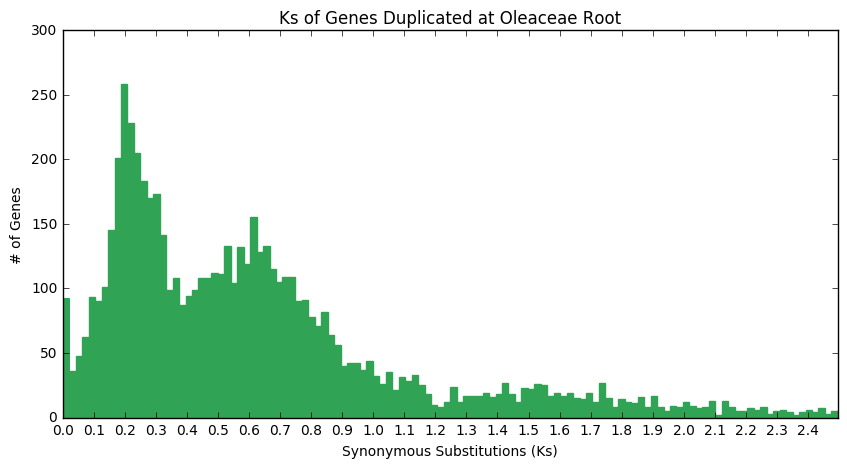

In [102]:
Ks_cap = converted_liz['Ks'] < 2.5
filtered_Ks = converted_liz[filtered_rows & Ks_cap]['Ks']
# pretty_hist("Ks of Genes Duplicated at Oleaceae Root", filtered_Ks, 
#             x_title="Synonymous Substitutions (Ks)", y_title="Number of Genes", bins = 120)

plt.xticks(np.arange(0, 2.6, .1))
h = filtered_Ks.hist(bins=120, figsize=(10,5), facecolor='#31a354', edgecolor='#31a354')
h.grid(False)
# h.linewidth(0)
h.set_xlabel("Synonymous Substitutions (Ks)")
h.set_ylabel('# of Genes')
h.set_title("Ks of Genes Duplicated at Oleaceae Root")

**Conclusion** That looks the exact same as the population distribution.  Rooted copy number filtering was unsuccessful.  I need to switch datasets to a more recent simulations.  Homeologs may be necessary to make sure "gene family" doesn't diffuse the results too much.

**Pulling in WGD_rates_loose actually made it worse!  That’s impressive.**